In [ ]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot

np.random.seed(42)

# helper function to create plots
def plot(data, norm=mpl.colors.LogNorm()):
    _, ax = plt.subplots()
    ax.contourf(data, norm=norm)
    ax.invert_yaxis()
    ax.grid(False)
    plt.axis("off")
    plt.show()

# Fields Defined on River Networks

In earthkit-hydro, a river network is defined on a specific grid. All fields for any operations in earthkit-hydro are assumed to also be on this same grid i.e. any interpolation/regridding is assumed to have been done already.

Multidimensional (vector) fields are supported for all operations in earthkit-hydro. It is assumed that the input field is of shape `(dim1, dim2, ..., grid_x_size, grid_y_size)` i.e. the last two axes must be the river network grid, and all other variables such as timestep or ensemble member must be present in earlier axes.

# River Network Creation

There are two ways to make a river network, `river_network.load` (preferred) and `river_network.create` (for special use cases). `river_network.load` loads a precomputed optimised version of a river network, whilst `river_network.create` creates a river network from an input file. Unless the river network you wish to use is not provided by `river_network.load`, please use `river_network.load`.

You can also use the alias `load_river_network` instead of `river_network.load`, and `create_river_network` instead of `river_network.create`.

In [2]:
# Check what precomputed networks are available
ekh.river_network.available()

Available precomputed networks are:
 `ekh.river_network.load("efas", "5")`
 `ekh.river_network.load("efas", "4")`
 `ekh.river_network.load("glofas", "4")`
 `ekh.river_network.load("glofas", "3")`
 `ekh.river_network.load("cama_15min", "4")`
 `ekh.river_network.load("cama_06min", "4")`
 `ekh.river_network.load("cama_05min", "4")`
 `ekh.river_network.load("cama_03min", "4")`
 `ekh.river_network.load("hydrosheds_06min", "1")`
 `ekh.river_network.load("hydrosheds_05min", "1")`


In [3]:
river_network = ekh.river_network.load(domain="efas", river_network_version="5")

River network not found in cache (/etc/ecmwf/ssd/ssd1/jupyterhub/ecm7348-jupyterhub/tmpdirs/ecm7348.32431785/tmpumif0ql2_earthkit_hydro/0.1_ea6b02b5935bacc00a2bd85aa78790267760263c88ebcac1cf425e5bcc773645.joblib).
River network loaded, saving to cache (/etc/ecmwf/ssd/ssd1/jupyterhub/ecm7348-jupyterhub/tmpdirs/ecm7348.32431785/tmpumif0ql2_earthkit_hydro/0.1_ea6b02b5935bacc00a2bd85aa78790267760263c88ebcac1cf425e5bcc773645.joblib).


# Calculating Upstream Metrics

Given a river network, a common task is to compute an upstream sum, average or other metric for a field. In earthkit-hydro, this can be done through the `upstream` module. For example, to compute the upstream sum, one can use `upstream.sum` and analagously for `mean`, `max`, `min` and `product`.

It is also possible to use the lower-level function `calculate_upstream_metric`.

These functions take as input a field upon which to calculate the metric, and return a field.

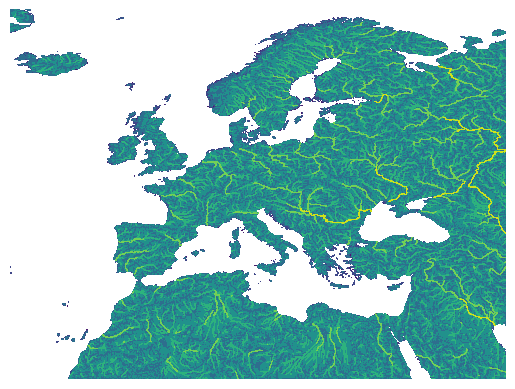

In [4]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
unit_field = np.ones(river_network.shape)

upstream_sum_field = ekh.upstream.sum(river_network, unit_field)

plot(upstream_sum_field)

We can also compute other metrics, such as weighted averages.

In [5]:
random_field = np.random.rand(*river_network.shape)
random_weights = np.random.rand(*river_network.shape)
upstream_sum_field = ekh.upstream.mean(river_network, random_field, weights=random_weights)

And earthkit-hydro also supports vector fields.

In [6]:
vector_field = np.random.rand(2, 3, *river_network.shape)
upstream_sum_field = ekh.upstream.max(river_network, vector_field)

# Calculating Catchment Metrics

Instead of computing the upstream metric over the entire field, often one is only interested in computing it for certain points (typically, stations and river gauges). The points upstream of a station define the catchment attached to the station, hence we provide the functions `catchments.sum`, `catchments.max`, `catchments.min`, `catchments.mean` and `catchments.product`.

It is also possible to use the lower-level function `calculate_catchment_metric`.

These functions take as input a field, and return a dictionary of {station: metric} pairs.

In [ ]:
points = [(1801, 4529), (886, 3999), (1621, 3298)]
random_field = np.random.rand(2, *river_network.shape) # vector field
random_weights = np.random.rand(2, *river_network.shape) # vector field

catchment_metric_at_points = ekh.catchments.mean(river_network, random_field, points)
print(catchment_metric_at_points)

{(np.int64(1801), np.int64(4529)): array([0.49982096, 0.50016607]), (np.int64(886), np.int64(3999)): array([0.4997279 , 0.49947184]), (np.int64(1621), np.int64(3298)): array([0.50007982, 0.49964425])}


# Finding Catchments and Subcatchments

Another common task is finding the catchments or subcatchments defined by a series of points (possibly stations). In earthkit-hydro, this is readily available with `catchments.find` and `subcatchments.find`, respectively.

As an alias, one can use `find_catchments` instead of `catchments.find` and `find_subcatchments` instead of `subcatchments.find`.

In [ ]:
# create or load the points of interest
points_matrix = np.zeros(river_network.shape)

# largest catchment's sink
points_matrix[1801, 4529] = 5  # given label 5
# point within largest catchment but not the sink
points_matrix[886, 3999] = 2 # given label 2
# separate catchment
points_matrix[1621, 3298] = 1 # given label 1

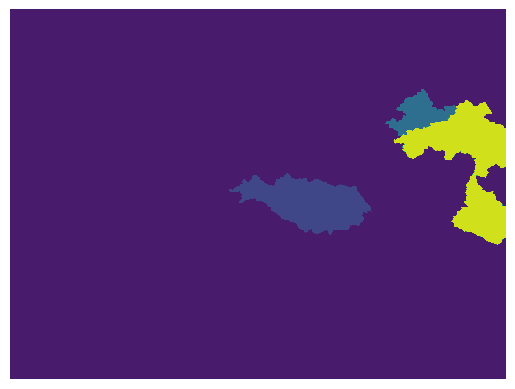

In [ ]:
# find and plot the subcatchments
subcatchment_field = ekh.subcatchments.find(river_network, points_matrix)

plot(subcatchment_field, norm=None)

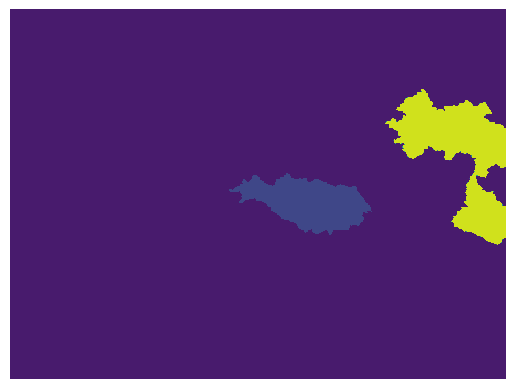

In [ ]:
# find and plot the catchments
catchment_field = ekh.catchments.find(river_network, points_matrix)

plot(catchment_field, norm=None)

# Computing Subcatchment Metrics

When points/stations are located on the same river basin, computing statistics on the subcatchments attached to the stations can be done through the `subcatchments` module.

Analagously to catchments, earthkit-hydro provides `subcatchments.sum`, `subcatchments.max`, `subcatchments.min`, `subcatchments.mean` and `subcatchments.product`.

It is also possible to use the lower-level function `calculate_subcatchment_metric`.

In [ ]:
points = [(1801, 4529), (886, 3999), (1621, 3298)]
random_field = np.random.rand(2, *river_network.shape) # vector field
random_weights = np.random.rand(2, *river_network.shape) # vector field

subcatchment_metric_at_points = ekh.subcatchments.mean(river_network, random_field, points)
print(subcatchment_metric_at_points)

{(np.int64(1801), np.int64(4529)): array([0.50108684, 0.4993055 ]), (np.int64(886), np.int64(3999)): array([0.50126192, 0.50022543]), (np.int64(1621), np.int64(3298)): array([0.49990213, 0.49982035])}


# Computing Zonal Metrics

If one wishes to compute a metric over an arbitrary area that isn't a catchment or subcatchment, this is also possible with `zonal.sum`, `zonal.max`, `zonal.min`, `zonal.mean` and `zonal.product`.

It is also possible to use the lower-level function `calculate_zonal_metric`, which is used in the computation of subcatchments statistics.

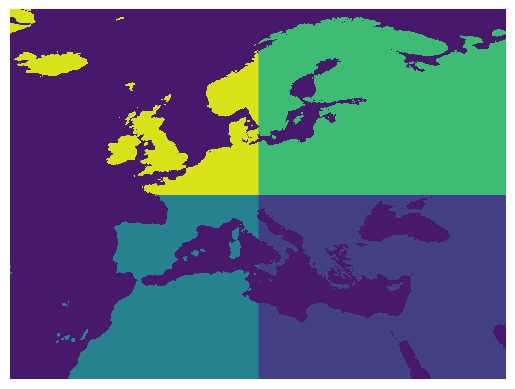

In [12]:
# generate some labelled regions defining where to compute the metric on
labels = np.empty(river_network.shape)
labels[river_network.shape[0]//2:, river_network.shape[1]//2:] = 1
labels[river_network.shape[0]//2:, :river_network.shape[1]//2] = 2
labels[:river_network.shape[0]//2, river_network.shape[1]//2:] = 3
labels[:river_network.shape[0]//2, :river_network.shape[1]//2] = 4
labels_missing_value = 0
labels[~river_network.mask] = labels_missing_value # give anything outside the river network a missing value of 0

plot(labels, norm=None)

In [13]:
random_field = np.random.rand(*river_network.shape)

metric_for_labels = ekh.zonal.mean(random_field, labels, labels_mv=labels_missing_value)
print(metric_for_labels)

{np.float64(1.0): np.float64(0.5000032969880438), np.float64(2.0): np.float64(0.4998112473407463), np.float64(3.0): np.float64(0.5001388694236336), np.float64(4.0): np.float64(0.49993903902234904)}


And we can return as a field instead of a dictionary if desired.

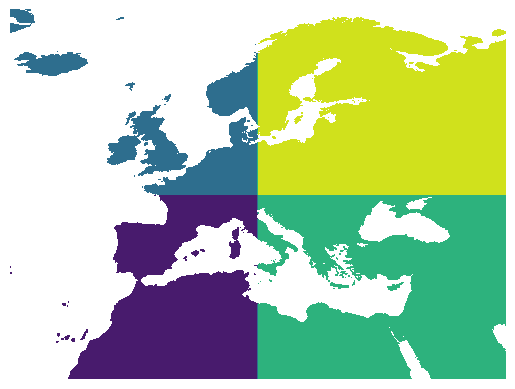

In [14]:
metric_field = ekh.zonal.mean(random_field, labels, labels_mv=labels_missing_value, return_field=True)

plot(metric_field, norm=None)

# Distances and Lengths

Another common operation on river networks is computing distances from points (often stations or river gauges) or lengths of river networks. In earthkit-hydro, we draw a distinction between distances (which can be computed via the `ekh.distance` module) and lengths (which can be computed via the `ekh.length` module) of river networks. There is support for any of maximum/minimum upstream/downstream distances/lengths.

Distances in earthkit-hydro are determined based on knowledge of the distance from any cell to its downstream cell. A distance of a given path from a point a to b is then the sum of the downstream distances starting at point a until the point b is reached.

By default in earthkit-hydro, the distance from any cell to its downstream cell is assumed to be 1.

/var/folders/td/yqnxcqpx39dc855vwjtv5hj40000gn/T/ipykernel_31471/3808429659.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(data, norm=norm)


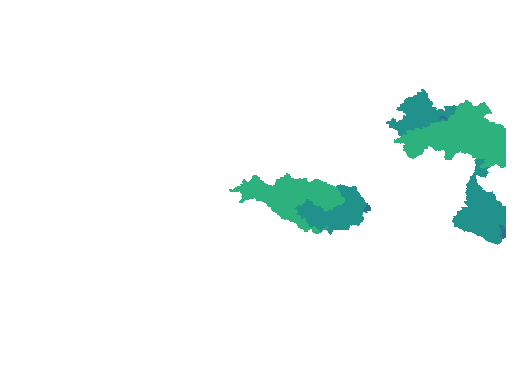

In [15]:
points = [(1801, 4529), (886, 3999), (1621, 3298)]
dist = ekh.distance.min(river_network, points, upstream=True, downstream=False)
plot(dist)

One can also specify manually the downstream distances, and/or calculate a maximum distance.

/var/folders/td/yqnxcqpx39dc855vwjtv5hj40000gn/T/ipykernel_31471/3808429659.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(data, norm=norm)


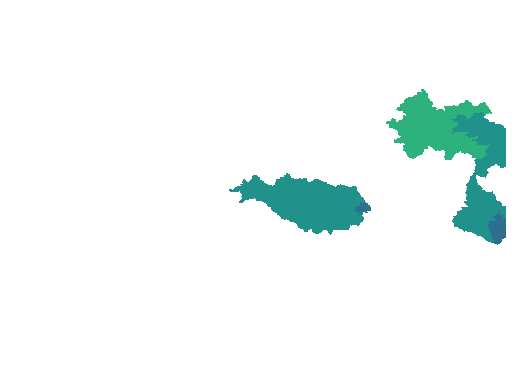

In [16]:
weights = np.random.rand(*river_network.shape)
dist = ekh.distance.max(river_network, points, weights, upstream=True, downstream=False)
plot(dist)

Lengths are calculated differently, based on the length of rivers within a gridcell. Note that this is not equivalent to the distance to a downstream cell. The length of a given path between a gridcell a and b is the the sum of all the lengths on the path, *including* the lengths of cells a and b.

By default the length of each gridcell is assumed to be 1. This means by default, the length between any two points will be the distance + 1 since it includes the both the starting and end cells in the calculation.

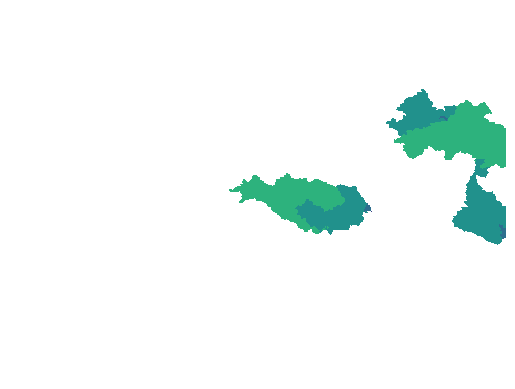

In [17]:
length = ekh.length.min(river_network, points, upstream=True, downstream=False)
plot(length)

Analagously to distance, ne can also specify manually the river lengths in each gricell, and/or calculate a maximum length.

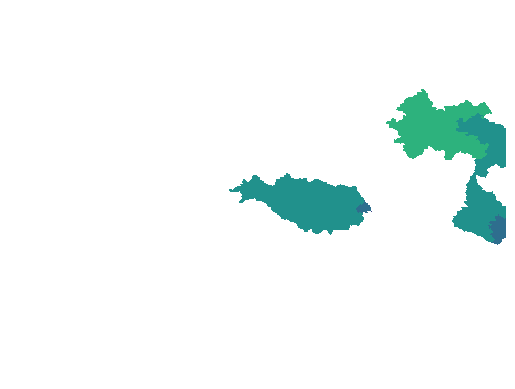

In [18]:
weights = np.random.rand(*river_network.shape)
length = ekh.length.max(river_network, points, weights, upstream=True, downstream=False)
plot(length)

We also provide convenience functions to calculate shortest/longest lengths/distances to sources and sinks.
```
ekh.distance.to_source(river_network, weights, path='shortest')
ekh.distance.to_sink(river_network, weights, path='shortest')
ekh.length.to_source(river_network, weights, path='shortest')
ekh.length.to_sink(river_network, weights, path='shortest')
```

# Subnetwork

Another common function is to compute a subnetwork of the original river network, which is easily possible using the `create_subnetwork` method of the river network.

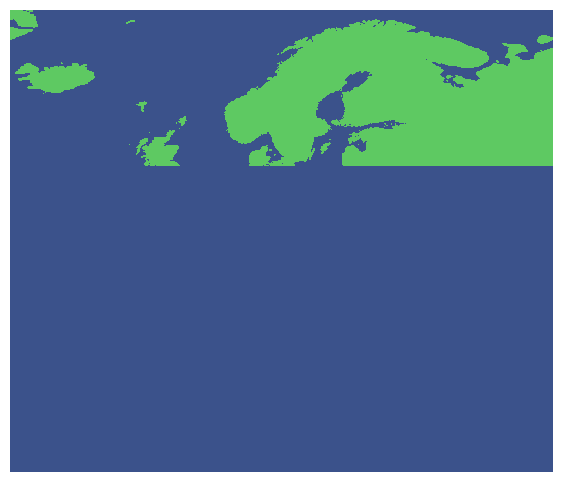

In [15]:
# create a subnetwork given a mask of northern Europe
mask = np.full(river_network.shape, False)
mask[:1000] = True
north_europe_river_network = river_network.create_subnetwork(mask)

plot(north_europe_river_network.mask, norm=None)

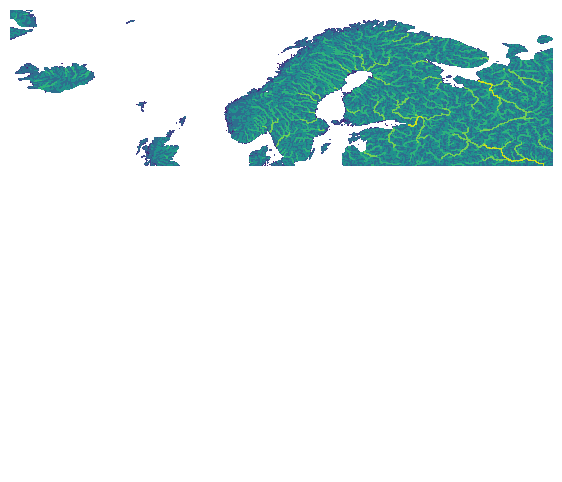

In [16]:
# compute the upstream sum on this new river network
upstream_sum_field = ekh.upstream.sum(north_europe_river_network, unit_field)
plot(upstream_sum_field)

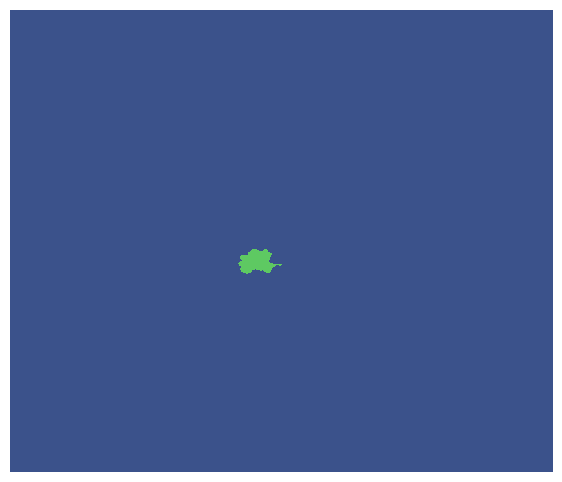

In [ ]:
# create a subnetwork of a river catchment
# can find the mask directly by doing catchment with boolean arrays
points_matrix = np.full(river_network.shape, False)
points_matrix[1636, 2267] = True  # Po river catchment sink
catchment_mask = ekh.catchments.find(river_network, points_matrix, mv=False)
po_catchment_network = river_network.create_subnetwork(catchment_mask)
plot(po_catchment_network.mask, norm=None)

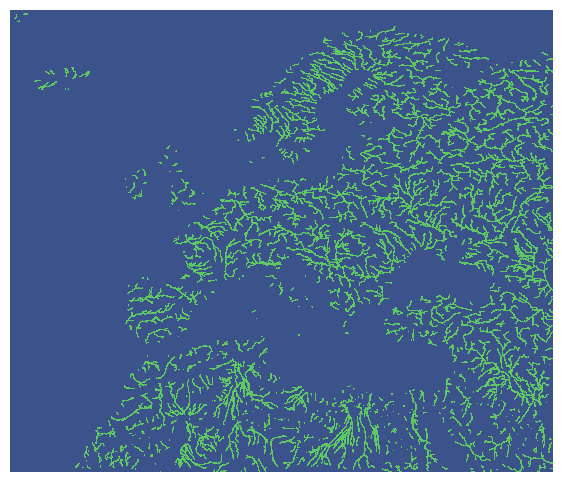

In [18]:
# create a subnetwork of large rivers only
accuflux_field = ekh.upstream.sum(river_network, unit_field)
large_rivers = accuflux_field > 1000
large_river_network = river_network.create_subnetwork(large_rivers)
plot(large_river_network.mask, norm=None)

# Upstream & Downstream

It is also possible to move a river network downstream or upstream with the `move_downstream` and `move_upstream` methods, respectively.

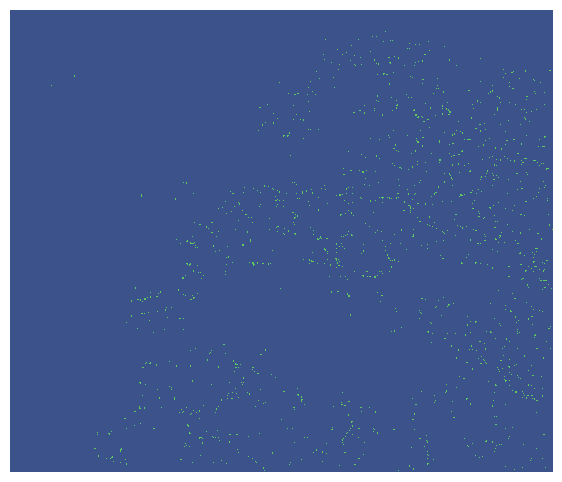

In [19]:
# find confluences of the large rivers
upstream_field = ekh.move_downstream(large_river_network, unit_field)
plot(upstream_field > 1, norm=None)

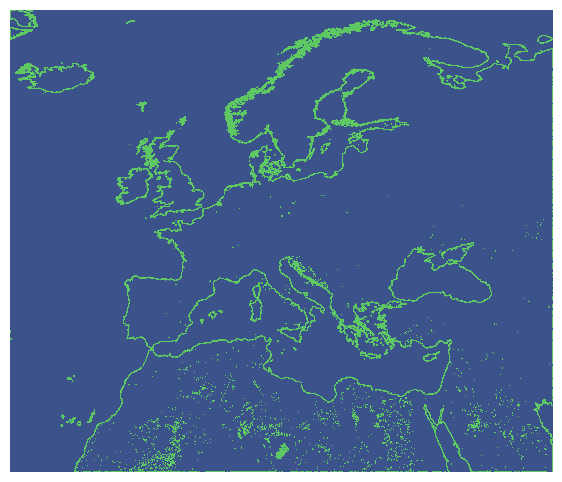

In [20]:
# find sinks of the original river network
downstream_field = ekh.move_upstream(river_network, unit_field)
plot(downstream_field == 0, norm=None)

And these functions also support vector fields.

In [21]:
random_field = np.random.rand(3,4,*river_network.shape)
downstream_field = ekh.move_upstream(river_network, random_field)

# Example with earthkit and Precipitation Maps

Finally, earthkit-hydro is part of the earthkit ecosystem and interplays with other earthkit packages.

In [22]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

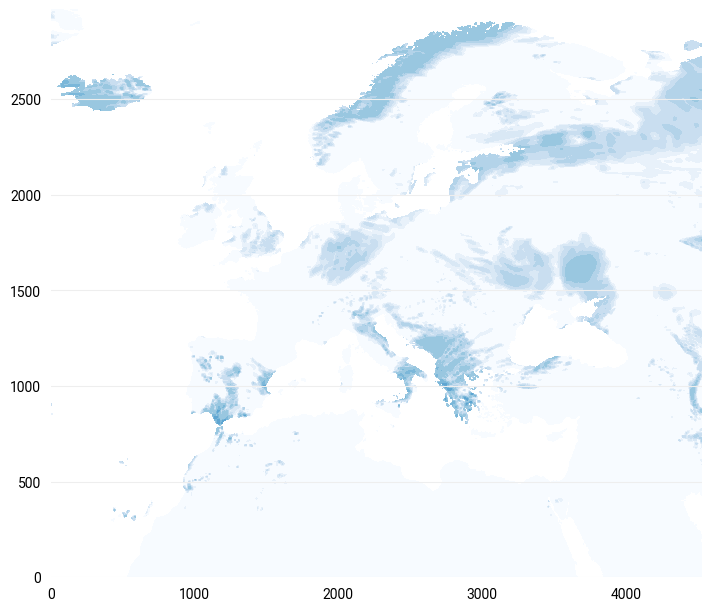

In [23]:
# load example precipitation field
precipitation_field = ekd.from_source(
    "sample",
    "R06a.nc",
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

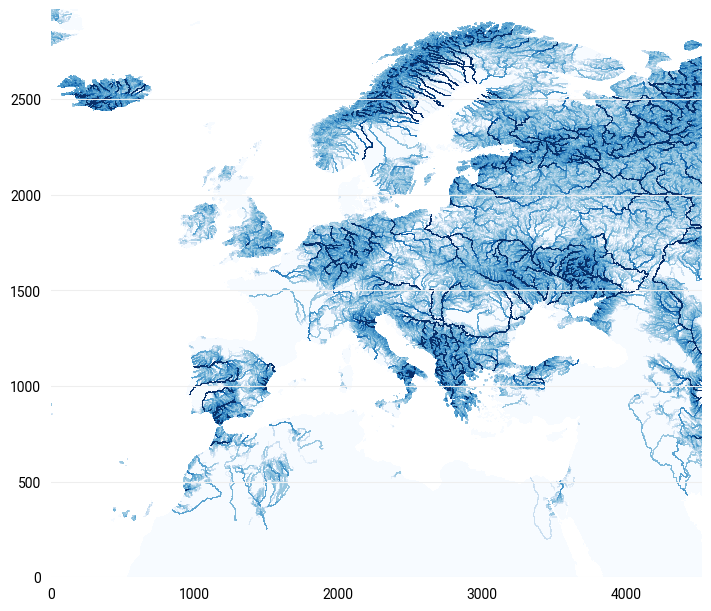

In [24]:
# Here using the flow_downstream function to compute the accumulated flux, which is equivalent to upsteam.sum(river_network, precipitation_field)
accuflux_field = ekh.flow_downstream(river_network, precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)